# 🌸 꽃 분류 CNN 모델: Daisy vs Dandelion

## 📋 프로젝트 개요

### 🎯 목표
- **주목적**: 딥러닝을 활용한 꽃 이미지 이진 분류 시스템 구현
- **분류 대상**: Daisy(데이지) vs Dandelion(민들레)
- **기술 스택**: TensorFlow/Keras를 활용한 CNN(Convolutional Neural Network)

### 📊 프로젝트 구조
1. **데이터 준비**: 이미지 전처리 및 정규화
2. **모델 설계**: CNN 아키텍처 구성
3. **학습 및 평가**: 모델 훈련 및 성능 측정
4. **결과 분석**: 시각화 및 성능 분석

### 🔧 핵심 기능
- 이미지 데이터 자동 전처리 파이프라인
- 최적화된 CNN 모델 아키텍처
- 실시간 학습 모니터링 및 시각화
- 상세한 성능 평가 및 분석 도구


## 🛠️ 1. 환경 설정

### 1.1 필요한 라이브러리 Import


In [21]:
# 데이터 처리 및 시각화
import numpy as np 
import os 
import random 
import pandas as pd
import PIL.Image as pilimg 
import imghdr

# 딥러닝 프레임워크
import tensorflow as tf 
from tensorflow.keras import models, layers

# 머신러닝 유틸리티
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 환경 설정 및 한글 폰트 설정
import platform

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['AppleGothic', 'Helvetica']
elif platform.system() == 'Windows':  # Windows
    plt.rcParams['font.family'] = ['Malgun Gothic', 'Arial']
else:  # Linux
    plt.rcParams['font.family'] = ['DejaVu Sans', 'NanumGothic']

plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정 확인
print(f"🎨 현재 설정된 폰트: {plt.rcParams['font.family']}")


print("="*50)
print("🚀 환경 설정 완료")
print("="*50)
print(f"📊 TensorFlow version: {tf.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print("📈 Matplotlib & Seaborn: 로드 완료")
print("✅ 모든 라이브러리가 성공적으로 로드되었습니다!")
print("="*50)


🎨 현재 설정된 폰트: ['Malgun Gothic', 'Arial']
🚀 환경 설정 완료
📊 TensorFlow version: 2.19.0
🔢 NumPy version: 2.1.3
📈 Matplotlib & Seaborn: 로드 완료
✅ 모든 라이브러리가 성공적으로 로드되었습니다!


### 1.2 데이터 경로 설정 및 구조 확인

꽃 이미지 데이터가 저장된 경로를 설정하고 데이터 구조를 확인합니다.

**📁 예상 데이터 구조:**
```markdown
flowers/
├── train/
│   ├── daisy/      (데이지 훈련 이미지)
│   └── dandelion/  (민들레 훈련 이미지)
└── test/
    ├── daisy/      (데이지 테스트 이미지)
    └── dandelion/  (민들레 테스트 이미지)
```


In [3]:
# 데이터 경로 설정 (여러 옵션 제공)
possible_paths = [
    "../../data/flowers",  # 상대 경로 (권장)
    "../../../data/flowers",  # 다른 상대 경로
    "C:/Users/ryan9/문서/GitHub/SeSac-AI-Developer-Notes-2025/07_Deep_Learning/data/flowers"  # 절대 경로
]

base_path = None
for path in possible_paths:
    if os.path.exists(path):
        base_path = path
        break

if base_path:
    print("="*50)
    print("📂 데이터 경로 설정 완료")
    print("="*50)
    print(f"🎯 사용 경로: {base_path}")
    print()
    
    # 폴더 구조 및 데이터 개수 확인
    print("📁 데이터 구조 및 파일 개수:")
    total_images = 0
    
    for split in ['train', 'test']:
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            print(f"  📂 {split}/")
            for flower in ['daisy', 'dandelion']:
                flower_path = os.path.join(split_path, flower)
                if os.path.exists(flower_path):
                    count = len([f for f in os.listdir(flower_path) 
                               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))])
                    total_images += count
                    print(f"    🌸 {flower}: {count}개 이미지")
                else:
                    print(f"    ❌ {flower}: 폴더 없음")
        else:
            print(f"  ❌ {split}/: 폴더 없음")
    
    print(f"\n📊 총 이미지 개수: {total_images}개")
    print("="*50)
    
else:
    print("❌ 데이터 경로를 찾을 수 없습니다.")
    print("다음 경로들을 확인하세요:")
    for path in possible_paths:
        print(f"  - {path}")
    print("\n💡 힌트: 노트북 파일이 올바른 위치에 있는지 확인하세요.")


📂 데이터 경로 설정 완료
🎯 사용 경로: ../../data/flowers

📁 데이터 구조 및 파일 개수:
  📂 train/
    🌸 daisy: 529개 이미지
    🌸 dandelion: 746개 이미지
  📂 test/
    🌸 daisy: 77개 이미지
    🌸 dandelion: 105개 이미지

📊 총 이미지 개수: 1457개


## 📊 2. 데이터 처리 파이프라인

### 2.1 데이터 전처리 함수

이미지 파일들을 읽어서 NumPy 배열로 변환하고 `.npz` 파일로 저장하는 함수들입니다.

#### 🔄 주요 전처리 단계:
1. **이미지 유효성 검사**: gif, png, jpeg, jpg 형식 확인
2. **크기 정규화**: 모든 이미지를 80×80 픽셀로 리사이즈
3. **레이블 인코딩**: daisy=0, dandelion=1
4. **데이터 직렬화**: 처리된 데이터를 .npz 형식으로 저장

#### ⚙️ 기술적 세부사항:
- **이미지 크기**: 80×80×3 (RGB 채널)
- **데이터 형식**: NumPy 배열 → NPZ 압축 형식
- **메모리 최적화**: 배치 단위 처리로 메모리 효율성 확보


In [4]:
def makeData(flower_name, label, isTrain=True):
    """
    특정 꽃 종류의 이미지 데이터를 처리하여 NumPy 배열로 변환
    
    Parameters:
    -----------
    flower_name : str
        꽃 이름 ('daisy' 또는 'dandelion')
    label : int
        레이블 값 (daisy=0, dandelion=1)
    isTrain : bool
        True면 train 폴더, False면 test 폴더에서 데이터 로드
        
    Returns:
    --------
    int : 처리된 이미지 수
    """
    # 경로 설정
    if base_path is None:
        print("❌ base_path가 설정되지 않았습니다. 먼저 데이터 경로를 설정하세요.")
        return 0
        
    subset = "train" if isTrain else "test"
    path = os.path.join(base_path, subset, flower_name)
    
    print(f"🔄 처리 중: {subset}/{flower_name}")
    print(f"📂 경로: {path}")
    
    if not os.path.exists(path):
        print(f"❌ 경로가 존재하지 않습니다: {path}")
        return 0
    
    data = []
    labels = []
    error_count = 0
    
    # 이미지 파일 목록 가져오기
    image_files = [f for f in os.listdir(path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    total_files = len(image_files)
    
    print(f"📊 총 {total_files}개 이미지 파일 발견")
    
    # 이미지 처리
    for i, filename in enumerate(image_files, 1):
        try:
            # 진행률 표시
            if i % 100 == 0 or i == total_files:
                progress = (i / total_files) * 100
                print(f"📈 진행률: {i}/{total_files} ({progress:.1f}%)")
            
            file_path = os.path.join(path, filename)
            
            # 이미지 형식 확인
            kind = imghdr.what(file_path)
            if kind not in ["gif", "png", "jpeg", "jpg"]:
                continue
                
            # 이미지 로드 및 전처리
            with pilimg.open(file_path) as img:
                # RGB 변환 (RGBA나 다른 형식 처리)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # 크기 조정
                resize_img = img.resize((80, 80), pilimg.Resampling.LANCZOS)
                pixel = np.array(resize_img)
                
                # 형태 검증
                if pixel.shape == (80, 80, 3):
                    data.append(pixel)
                    labels.append(label)
                    
        except Exception as e:
            error_count += 1
            if error_count <= 5:  # 처음 5개 오류만 출력
                print(f"⚠️  {filename} 처리 오류: {e}")
            elif error_count == 6:
                print("⚠️  추가 오류들은 로그에서 생략됩니다...")
    
    # 결과 저장
    savefileName = f"../../data/npz/imagedata{label}_{subset}.npz"
    
    if data:
        np.savez(savefileName, data=np.array(data), targets=np.array(labels))
        print(f"✅ 저장 완료: {savefileName}")
        print(f"📊 처리 결과: {len(data)}개 이미지 성공, {error_count}개 오류")
    else:
        print(f"❌ 처리된 이미지가 없습니다.")
    
    return len(data)


In [5]:
def initData():
    """
    모든 꽃 종류의 train/test 데이터를 처리하여 .npz 파일로 저장
    
    Returns:
    --------
    bool : 성공 여부
    """
    flowers = ["daisy", "dandelion"]
    
    print("="*60)
    print("🚀 데이터 초기화 프로세스 시작")
    print("="*60)
    
    # base_path 확인
    if base_path is None:
        print("❌ 데이터 경로가 설정되지 않았습니다.")
        return False
    
    # 기존 파일 확인
    existing_files = [f for f in os.listdir('.') 
                     if f.endswith('.npz') and f.startswith('imagedata')]
    
    if existing_files:
        print("📁 기존 .npz 파일 발견:")
        for file in existing_files:
            size = os.path.getsize(file) / (1024*1024)
            print(f"  - {file} ({size:.2f} MB)")
        
        response = input("\n덮어쓰시겠습니까? (y/N): ").lower()
        if response != 'y':
            print("🚫 작업이 취소되었습니다.")
            return False
        print()
    
    processing_results = []
    total_processed = 0
    start_time = pd.Timestamp.now()
    
    # 각 꽃 종류별 처리
    for i, flower in enumerate(flowers):
        print(f"\n🌸 {flower.upper()} 처리 중... (레이블: {i})")
        print("-" * 40)
        
        flower_results = {}
        
        # Train 데이터 처리
        print(f"📂 훈련 데이터 처리")
        train_count = makeData(flower, i, True)
        flower_results['train'] = train_count
        
        print(f"\n📂 테스트 데이터 처리")
        test_count = makeData(flower, i, False)
        flower_results['test'] = test_count
        
        total_count = train_count + test_count
        total_processed += total_count
        
        processing_results.append({
            'flower': flower,
            'label': i,
            'train_count': train_count,
            'test_count': test_count,
            'total_count': total_count
        })
        
        print(f"✅ {flower} 완료: Train {train_count}개, Test {test_count}개, 총 {total_count}개")
    
    # 처리 완료 및 결과 요약
    end_time = pd.Timestamp.now()
    duration = (end_time - start_time).total_seconds()
    
    print("\n" + "="*60)
    print("🎉 데이터 초기화 완료")
    print("="*60)
    
    # 결과 테이블 출력
    print("\n📊 처리 결과 요약:")
    result_df = pd.DataFrame(processing_results)
    print(result_df.to_string(index=False))
    
    print(f"\n⏱️  총 처리 시간: {duration:.1f}초")
    print(f"📈 총 처리 이미지: {total_processed}개")
    print(f"⚡ 평균 처리 속도: {total_processed/duration:.1f}개/초")
    
    # 생성된 파일 목록 및 크기 확인
    print("\n📄 생성된 .npz 파일들:")
    npz_files = [f for f in os.listdir('.') 
                if f.endswith('.npz') and f.startswith('imagedata')]
    
    total_size = 0
    for file in sorted(npz_files):
        size = os.path.getsize(file) / (1024*1024)  # MB 단위
        total_size += size
        print(f"  ✅ {file} ({size:.2f} MB)")
    
    print(f"\n💾 총 파일 크기: {total_size:.2f} MB")
    print("="*60)
    
    return total_processed > 0


### 2.2 데이터 로딩 및 정규화 함수

저장된 `.npz` 파일들을 로드하여 학습용 데이터셋을 준비하는 함수들입니다.


In [13]:
def loadData():
    """
    저장된 .npz 파일들을 로드하여 train/test 데이터셋 반환
    
    Returns:
    --------
    tuple : (X_train, y_train, X_test, y_test)
        - X_train, X_test : 이미지 데이터 (numpy.ndarray)
        - y_train, y_test : 레이블 데이터 (numpy.ndarray)
        실패 시 (None, None, None, None) 반환
    """
    print("="*50)
    print("📂 데이터 로딩 프로세스 시작")
    print("="*50)
    
    # npz 파일 경로 설정
    npz_path = "../../data/npz"
    
    # 필요한 파일 목록
    required_files = [
        "imagedata0_train.npz",  # daisy train
        "imagedata1_train.npz",  # dandelion train  
        "imagedata0_test.npz",   # daisy test
        "imagedata1_test.npz"    # dandelion test
    ]
    
    # 파일 존재 여부 확인
    missing_files = [f for f in required_files if not os.path.exists(os.path.join(npz_path, f))]
    if missing_files:
        print("❌ 누락된 데이터 파일:")
        for file in missing_files:
            print(f"  - {file}")
        print("\n💡 해결 방법: initData() 함수를 먼저 실행하여 데이터를 생성하세요.")
        return None, None, None, None
    
    print("✅ 모든 필요한 파일이 존재합니다.")
    
    datasets = {}
    
    # Train 데이터 로딩
    try:
        print("\n🔄 훈련 데이터 로딩...")
        
        # Daisy train 데이터
        with np.load(os.path.join(npz_path, "imagedata0_train.npz")) as f:
            daisy_train_data = f["data"]
            daisy_train_labels = f["targets"]
        
        # Dandelion train 데이터  
        with np.load(os.path.join(npz_path, "imagedata1_train.npz")) as f:
            dandelion_train_data = f["data"]
            dandelion_train_labels = f["targets"]
        
        # 훈련 데이터 결합
        X_train = np.concatenate([daisy_train_data, dandelion_train_data], axis=0)
        y_train = np.concatenate([daisy_train_labels, dandelion_train_labels], axis=0)
        
        print(f"  📊 Daisy 훈련 이미지: {len(daisy_train_data)}개")
        print(f"  📊 Dandelion 훈련 이미지: {len(dandelion_train_data)}개")
        print(f"  📊 총 훈련 데이터: {X_train.shape}")
        
        datasets['train'] = (X_train, y_train)
        
    except Exception as e:
        print(f"❌ 훈련 데이터 로딩 실패: {e}")
        return None, None, None, None

    # Test 데이터 로딩
    try:
        print("\n🔄 테스트 데이터 로딩...")
        
        # Daisy test 데이터
        with np.load(os.path.join(npz_path, "imagedata0_test.npz")) as f:
            daisy_test_data = f["data"]
            daisy_test_labels = f["targets"]
        
        # Dandelion test 데이터
        with np.load(os.path.join(npz_path, "imagedata1_test.npz")) as f:
            dandelion_test_data = f["data"]
            dandelion_test_labels = f["targets"]
        
        # 테스트 데이터 결합
        X_test = np.concatenate([daisy_test_data, dandelion_test_data], axis=0)
        y_test = np.concatenate([daisy_test_labels, dandelion_test_labels], axis=0)
        
        print(f"  📊 Daisy 테스트 이미지: {len(daisy_test_data)}개")
        print(f"  📊 Dandelion 테스트 이미지: {len(dandelion_test_data)}개")
        print(f"  📊 총 테스트 데이터: {X_test.shape}")
        
        datasets['test'] = (X_test, y_test)
        
    except Exception as e:
        print(f"❌ 테스트 데이터 로딩 실패: {e}")
        return X_train, y_train, None, None

    # 데이터 요약 및 검증
    print("\n" + "="*50)
    print("📊 데이터셋 요약 및 검증")
    print("="*50)
    
    print(f"🔹 훈련 데이터: {X_train.shape} | 레이블: {y_train.shape}")
    print(f"🔹 테스트 데이터: {X_test.shape} | 레이블: {y_test.shape}")
    print(f"🔹 이미지 크기: {X_train[0].shape}")
    print(f"🔹 픽셀 값 범위: {X_train.min()} ~ {X_train.max()}")
    print(f"🔹 데이터 타입: {X_train.dtype}")
    
    # 레이블 분포 확인
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    
    print(f"\n📈 레이블 분포:")
    print(f"  📚 훈련 세트: Daisy({unique_train[0]})={counts_train[0]}개, Dandelion({unique_train[1]})={counts_train[1]}개")
    print(f"  🧪 테스트 세트: Daisy({unique_test[0]})={counts_test[0]}개, Dandelion({unique_test[1]})={counts_test[1]}개")
    
    # 클래스 균형 확인
    train_balance = counts_train[0] / counts_train[1]
    test_balance = counts_test[0] / counts_test[1]
    print(f"\n⚖️  클래스 균형:")
    print(f"  📚 훈련 세트 비율: {train_balance:.2f}")
    print(f"  🧪 테스트 세트 비율: {test_balance:.2f}")
    
    if 0.5 <= train_balance <= 2.0 and 0.5 <= test_balance <= 2.0:
        print("  ✅ 클래스 균형이 양호합니다.")
    else:
        print("  ⚠️  클래스 불균형이 감지되었습니다. 데이터 증강을 고려하세요.")
    
    print("="*50)
    
    return X_train, y_train, X_test, y_test


## 🧠 3. CNN 모델 설계

### 3.1 모델 아키텍처 설계

Convolutional Neural Network를 구성하여 이진 분류 모델을 생성합니다.

#### 🏗️ 모델 구조:
```
입력 레이어: (80, 80, 3)
    ↓
Conv2D(64 filters, 3×3) + ReLU
    ↓
MaxPooling2D(2×2)  # 특징맵 크기 축소
    ↓
Conv2D(32 filters, 3×3) + ReLU  
    ↓
Flatten  # 1차원으로 변환
    ↓
Dense(128) + ReLU
    ↓
Dense(32) + ReLU
    ↓
Dense(1) + Sigmoid  # 이진 분류용 출력
```

#### 📊 설계 원리:
- **컨볼루션 레이어**: 이미지의 공간적 특징 추출
- **풀링 레이어**: 차원 축소 및 과적합 방지
- **완전연결 레이어**: 분류를 위한 고차원 특징 학습
- **시그모이드 활성화**: 이진 분류 확률 출력 (0~1)


In [7]:
def createModel(input_shape=(80, 80, 3), summary=True):
    """
    CNN 모델을 생성하고 컴파일하여 반환
    
    Parameters:
    -----------
    input_shape : tuple
        입력 이미지의 형태 (height, width, channels)
    summary : bool
        모델 구조 요약 출력 여부
        
    Returns:
    --------
    tf.keras.Model : 컴파일된 Keras 모델
    """
    print("="*50)
    print("🏗️ CNN 모델 생성 시작")
    print("="*50)
    
    # 모델 아키텍처 정의
    network = models.Sequential([
        # 입력 레이어
        layers.Input(shape=input_shape),
        
        # 첫 번째 컨볼루션 블록
        layers.Conv2D(
            filters=64, 
            kernel_size=(3, 3), 
            activation='relu',
            padding='same',
            name='conv2d_1'
        ),
        layers.MaxPooling2D(
            pool_size=(2, 2),
            name='maxpool2d_1'
        ),
        
        # 두 번째 컨볼루션 블록
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            activation='relu',
            padding='same',
            name='conv2d_2'
        ),
        layers.MaxPooling2D(
            pool_size=(2, 2),
            name='maxpool2d_2'
        ),
        
        # 분류기 부분
        layers.Flatten(name='flatten'),
        
        # 완전연결 레이어들
        layers.Dense(
            units=128, 
            activation='relu',
            name='dense_1'
        ),
        layers.Dropout(0.3, name='dropout_1'),  # 과적합 방지
        
        layers.Dense(
            units=32, 
            activation='relu',
            name='dense_2'
        ),
        layers.Dropout(0.2, name='dropout_2'),  # 과적합 방지
        
        # 출력 레이어 (이진 분류)
        layers.Dense(
            units=1, 
            activation='sigmoid',
            name='output'
        )
    ], name='FlowerClassifier')
    
    # 모델 컴파일
    network.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',  # 이진분류용 손실함수
        metrics=['accuracy', 'precision', 'recall']  # 다양한 평가 지표
    )
    
    print("✅ 모델 생성 및 컴파일 완료!")
    
    # 모델 정보 출력
    if summary:
        print("\n📋 모델 구조 요약:")
        print("-" * 50)
        network.summary()
        
        # 추가 모델 정보
        total_params = network.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in network.trainable_weights])
        
        print(f"\n📊 모델 파라미터 정보:")
        print(f"  🔹 총 파라미터: {total_params:,}")
        print(f"  🔹 훈련 가능한 파라미터: {trainable_params:,}")
        print(f"  🔹 고정 파라미터: {total_params - trainable_params:,}")
        
        # 모델 크기 추정
        model_size_mb = (total_params * 4) / (1024 * 1024)  # float32 기준
        print(f"  🔹 예상 모델 크기: {model_size_mb:.2f} MB")
    
    print("="*50)
    
    return network


### 3.2 데이터 전처리 및 정규화

모델 학습을 위해 이미지 데이터를 정규화하고 전처리합니다.

#### 🔄 전처리 단계:
- **픽셀 값 정규화**: 0~255 범위를 0~1 범위로 변환 (÷255)
- **데이터 셔플링**: 학습 데이터의 순서를 무작위로 섞기
- **데이터 검증**: 형태와 값 범위 확인


In [8]:
def preprocessing(shuffle=True, random_state=42):
    """
    데이터를 로드하고 전처리하여 학습 준비
    
    Parameters:
    -----------
    shuffle : bool
        훈련 데이터 셔플링 여부
    random_state : int
        셔플링 시 사용할 랜덤 시드
        
    Returns:
    --------
    tuple : (X_train_scaled, y_train, X_test_scaled, y_test)
        정규화되고 전처리된 데이터셋
        실패 시 (None, None, None, None) 반환
    """
    print("="*50)
    print("🔄 데이터 전처리 프로세스 시작")
    print("="*50)
    
    # 1. 데이터 로딩
    print("📂 1단계: 데이터 로딩")
    X_train, y_train, X_test, y_test = loadData()
    
    if X_train is None:
        print("❌ 데이터 로딩 실패")
        return None, None, None, None
    
    print("✅ 데이터 로딩 완료")
    
    # 2. 데이터 검증
    print(f"\n🔍 2단계: 데이터 검증")
    print(f"  📊 훈련 데이터: {X_train.shape}, 타입: {X_train.dtype}")
    print(f"  📊 테스트 데이터: {X_test.shape}, 타입: {X_test.dtype}")
    print(f"  📊 픽셀 값 범위: {X_train.min()} ~ {X_train.max()}")
    
    # 데이터 타입 확인
    if X_train.dtype != np.uint8 and (X_train.min() < 0 or X_train.max() > 255):
        print("⚠️  비정상적인 픽셀 값 범위 감지")
    else:
        print("✅ 픽셀 값 범위 정상")
    
    # 3. 데이터 정규화
    print(f"\n⚡ 3단계: 픽셀 값 정규화 (0~255 → 0~1)")
    X_train_scaled = X_train.astype(np.float32) / 255.0
    X_test_scaled = X_test.astype(np.float32) / 255.0
    
    print(f"  ✅ 정규화 완료")
    print(f"  📊 훈련 데이터 범위: {X_train_scaled.min():.6f} ~ {X_train_scaled.max():.6f}")
    print(f"  📊 테스트 데이터 범위: {X_test_scaled.min():.6f} ~ {X_test_scaled.max():.6f}")
    
    # 4. 데이터 셔플링 (훈련 데이터만)
    if shuffle:
        print(f"\n🔀 4단계: 훈련 데이터 셔플링")
        np.random.seed(random_state)
        shuffle_idx = np.random.permutation(len(X_train_scaled))
        X_train_scaled = X_train_scaled[shuffle_idx]
        y_train = y_train[shuffle_idx]
        print(f"  ✅ 셔플링 완료 (시드: {random_state})")
    else:
        print(f"\n⏭️ 4단계: 셔플링 건너뛰기")
    
    # 5. 레이블 검증 및 분포 확인
    print(f"\n📈 5단계: 레이블 분석")
    
    # 레이블 형태 확인
    print(f"  📊 훈련 레이블: {y_train.shape}, 타입: {y_train.dtype}")
    print(f"  📊 테스트 레이블: {y_test.shape}, 타입: {y_test.dtype}")
    
    # 레이블 값 확인
    unique_train_labels = np.unique(y_train)
    unique_test_labels = np.unique(y_test)
    
    print(f"  📊 훈련 세트 레이블: {unique_train_labels}")
    print(f"  📊 테스트 세트 레이블: {unique_test_labels}")
    
    # 레이블 분포
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    
    print(f"\n📊 클래스 분포:")
    train_total = len(y_train)
    test_total = len(y_test)
    
    for label, count in zip(unique_train, counts_train):
        class_name = "Daisy" if label == 0 else "Dandelion"
        percentage = (count / train_total) * 100
        print(f"  📚 훈련 - {class_name}: {count}개 ({percentage:.1f}%)")
    
    for label, count in zip(unique_test, counts_test):
        class_name = "Daisy" if label == 0 else "Dandelion"  
        percentage = (count / test_total) * 100
        print(f"  🧪 테스트 - {class_name}: {count}개 ({percentage:.1f}%)")
    
    # 6. 메모리 사용량 확인
    print(f"\n💾 6단계: 메모리 사용량")
    train_memory = X_train_scaled.nbytes / (1024**2)  # MB
    test_memory = X_test_scaled.nbytes / (1024**2)   # MB
    total_memory = train_memory + test_memory
    
    print(f"  📊 훈련 데이터: {train_memory:.2f} MB")
    print(f"  📊 테스트 데이터: {test_memory:.2f} MB")
    print(f"  📊 총 메모리: {total_memory:.2f} MB")
    
    print("\n" + "="*50)
    print("✅ 데이터 전처리 완료")
    print("="*50)
    
    return X_train_scaled, y_train, X_test_scaled, y_test


## 🚀 4. 모델 학습 및 평가

### 4.1 통합 학습 파이프라인

전체 딥러닝 파이프라인을 실행하는 메인 함수입니다:

#### 📋 학습 프로세스:
1. **데이터 전처리**: 로딩, 정규화, 셔플링
2. **모델 생성**: CNN 아키텍처 구성 및 컴파일  
3. **모델 학습**: 훈련 데이터로 모델 훈련
4. **성능 평가**: 테스트 데이터로 모델 평가
5. **결과 분석**: 학습 과정 및 성능 분석


In [9]:
def main(epochs=10, batch_size=32, validation_split=0.0, save_model=False, model_name="flower_classifier"):
    """
    전체 학습 파이프라인을 실행하는 메인 함수
    
    Parameters:
    -----------
    epochs : int
        학습 에포크 수 (기본값: 10)
    batch_size : int
        배치 크기 (기본값: 32)
    validation_split : float
        훈련 데이터에서 검증용으로 분할할 비율 (0.0~1.0)
    save_model : bool
        모델 저장 여부
    model_name : str
        저장할 모델 파일명 (확장자 제외)
        
    Returns:
    --------
    tuple : (model, history, results)
        - model: 훈련된 모델
        - history: 학습 기록
        - results: 평가 결과 딕셔너리
    """
    print("="*70)
    print("🌸 꽃 분류 CNN 모델 학습 파이프라인 시작")
    print("="*70)
    
    start_time = pd.Timestamp.now()
    
    # 학습 설정 출력
    print(f"⚙️ 학습 설정:")
    print(f"  🔹 에포크 수: {epochs}")
    print(f"  🔹 배치 크기: {batch_size}")
    print(f"  🔹 검증 분할: {validation_split}")
    print(f"  🔹 모델 저장: {'예' if save_model else '아니요'}")
    if save_model:
        print(f"  🔹 모델명: {model_name}")
    print()
    
    # 1. 데이터 전처리
    print("📊 1단계: 데이터 전처리")
    print("-" * 50)
    
    X_train, y_train, X_test, y_test = preprocessing()
    
    if X_train is None:
        print("❌ 데이터 전처리 실패. 먼저 initData() 함수를 실행하세요.")
        return None, None, None
    
    # 2. 모델 생성
    print("\n🧠 2단계: 모델 생성")
    print("-" * 50)
    
    model = createModel(summary=True)
    
    # 3. 콜백 설정
    print("\n⚙️ 3단계: 콜백 설정")
    print("-" * 50)
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.0001,
            verbose=1
        )
    ]
    
    if save_model:
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}_best.h5",
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
        callbacks.append(checkpoint_callback)
    
    print(f"  ✅ 콜백 설정 완료: {len(callbacks)}개")
    for i, callback in enumerate(callbacks, 1):
        print(f"    {i}. {callback.__class__.__name__}")
    
    # 4. 모델 학습
    print(f"\n🎯 4단계: 모델 학습")
    print("-" * 50)
    print(f"  🚀 학습 시작...")
    
    # 검증 데이터 설정
    if validation_split > 0:
        validation_data = None
        print(f"  📊 훈련 데이터에서 {validation_split*100:.1f}% 검증용으로 분할")
    else:
        validation_data = (X_test, y_test)
        validation_split = 0.0
        print(f"  📊 별도 테스트 세트를 검증용으로 사용")
    
    try:
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=1
        )
        
        training_time = pd.Timestamp.now() - start_time
        print(f"\n✅ 학습 완료! (소요시간: {training_time.total_seconds():.1f}초)")
        
    except Exception as e:
        print(f"❌ 학습 중 오류 발생: {e}")
        return None, None, None
    
    # 5. 모델 평가
    print(f"\n📊 5단계: 모델 성능 평가")
    print("-" * 50)
    
    # 훈련 데이터 평가
    print("🔍 훈련 데이터 평가...")
    train_results = model.evaluate(X_train, y_train, verbose=0)
    train_metrics = dict(zip(model.metrics_names, train_results))
    
    # 테스트 데이터 평가
    print("🔍 테스트 데이터 평가...")
    test_results = model.evaluate(X_test, y_test, verbose=0)
    test_metrics = dict(zip(model.metrics_names, test_results))
    
    # 결과 정리
    results = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'training_time': training_time.total_seconds(),
        'epochs_completed': len(history.history['loss']),
        'best_epoch': np.argmax(history.history['val_accuracy']) + 1 if 'val_accuracy' in history.history else len(history.history['loss'])
    }
    
    # 결과 출력
    print(f"\n📈 최종 성능 결과:")
    print(f"  📚 훈련 세트:")
    for metric, value in train_metrics.items():
        print(f"    🔹 {metric}: {value:.4f}")
    
    print(f"  🧪 테스트 세트:")
    for metric, value in test_metrics.items():
        print(f"    🔹 {metric}: {value:.4f}")
    
    # 일반화 성능 분석
    accuracy_gap = train_metrics.get('accuracy', 0) - test_metrics.get('accuracy', 0)
    print(f"\n🎯 일반화 성능 분석:")
    print(f"  🔹 정확도 차이: {accuracy_gap:.4f}")
    
    if accuracy_gap > 0.15:
        print(f"  ⚠️  심각한 과적합 감지")
        print(f"      → 정규화 강화, 드롭아웃 증가, 데이터 증강 고려")
    elif accuracy_gap > 0.05:
        print(f"  ⚠️  경미한 과적합 감지")
        print(f"      → 조기 종료, 정규화 추가 고려")
    else:
        print(f"  ✅ 양호한 일반화 성능")
    
    # 6. 모델 저장
    if save_model:
        print(f"\n💾 6단계: 모델 저장")
        print("-" * 50)
        
        try:
            final_model_path = f"{model_name}_final.h5"
            model.save(final_model_path)
            print(f"  ✅ 최종 모델 저장: {final_model_path}")
            
            # 모델 정보 저장
            model_info = {
                'model_name': model_name,
                'training_time': training_time.total_seconds(),
                'epochs': epochs,
                'batch_size': batch_size,
                'final_metrics': test_metrics,
                'save_time': pd.Timestamp.now().isoformat()
            }
            
            import json
            info_path = f"{model_name}_info.json"
            with open(info_path, 'w', encoding='utf-8') as f:
                json.dump(model_info, f, indent=2, ensure_ascii=False)
            print(f"  ✅ 모델 정보 저장: {info_path}")
            
        except Exception as e:
            print(f"  ❌ 모델 저장 실패: {e}")
    
    # 최종 요약
    total_time = pd.Timestamp.now() - start_time
    print(f"\n" + "="*70)
    print(f"🎉 파이프라인 완료")
    print(f"="*70)
    print(f"⏱️  총 소요시간: {total_time.total_seconds():.1f}초")
    print(f"🎯 최종 테스트 정확도: {test_metrics.get('accuracy', 0)*100:.2f}%")
    print(f"📊 학습된 에포크: {results['epochs_completed']}/{epochs}")
    print(f"🏆 최고 성능 에포크: {results['best_epoch']}")
    print("="*70)
    
    return model, history, results


## 📊 5. 결과 분석 및 시각화

### 5.1 학습 과정 시각화 및 상세 분석

학습된 모델의 성능을 다각도로 분석하고 시각화하는 도구들입니다.


In [10]:
def plot_training_history(history, save_path=None):
    """
    학습 과정의 손실값과 정확도 변화를 시각화
    
    Parameters:
    -----------
    history : tf.keras.callbacks.History
        모델 학습 기록
    save_path : str, optional
        그래프 저장 경로
    """
    if history is None:
        print("❌ 학습 기록이 없습니다.")
        return
    
    print("📊 학습 곡선 시각화 중...")
    
    # 학습 기록에서 메트릭 추출
    metrics = list(history.history.keys())
    train_metrics = [m for m in metrics if not m.startswith('val_')]
    val_metrics = [m for m in metrics if m.startswith('val_')]
    
    n_metrics = len(train_metrics)
    fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
    
    if n_metrics == 1:
        axes = [axes]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, metric in enumerate(train_metrics):
        ax = axes[i]
        
        # 훈련 메트릭 플롯
        epochs = range(1, len(history.history[metric]) + 1)
        ax.plot(epochs, history.history[metric], 
               color=colors[0], marker='o', markersize=4, 
               label=f'Training {metric.title()}', linewidth=2)
        
        # 검증 메트릭 플롯 (있는 경우)
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            ax.plot(epochs, history.history[val_metric], 
                   color=colors[1], marker='s', markersize=4,
                   label=f'Validation {metric.title()}', linewidth=2)
        
        # 그래프 설정
        ax.set_title(f'{metric.title()} over Epochs', fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(metric.title(), fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # 최적값 표시
        if val_metric in history.history:
            if 'loss' in metric:
                best_epoch = np.argmin(history.history[val_metric]) + 1
                best_value = min(history.history[val_metric])
            else:
                best_epoch = np.argmax(history.history[val_metric]) + 1
                best_value = max(history.history[val_metric])
            
            ax.axvline(x=best_epoch, color=colors[2], linestyle='--', alpha=0.7)
            ax.text(best_epoch, best_value, f'Best: {best_value:.3f}\\nEpoch: {best_epoch}',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[2], alpha=0.3),
                   fontsize=9, ha='center')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✅ 학습 곡선 저장: {save_path}")
    
    plt.show()
    
    # 학습 요약 출력
    final_epoch = len(history.history['loss'])
    print(f"\n📈 학습 요약:")
    print(f"  🔹 총 에포크: {final_epoch}")
    
    for metric in train_metrics:
        final_train = history.history[metric][-1]
        val_metric = f'val_{metric}'
        
        if val_metric in history.history:
            final_val = history.history[val_metric][-1]
            print(f"  🔹 최종 {metric}: 훈련 {final_train:.4f}, 검증 {final_val:.4f}")
            
            if 'loss' in metric:
                best_val = min(history.history[val_metric])
                best_epoch = np.argmin(history.history[val_metric]) + 1
            else:
                best_val = max(history.history[val_metric])
                best_epoch = np.argmax(history.history[val_metric]) + 1
            
            print(f"  🔹 최고 검증 {metric}: {best_val:.4f} (에포크 {best_epoch})")
        else:
            print(f"  🔹 최종 {metric}: {final_train:.4f}")

print("✅ 학습 곡선 시각화 함수 정의 완료")


✅ 학습 곡선 시각화 함수 정의 완료


### 5.2 추가 분석 및 시각화 도구

모델 성능을 더 자세히 분석하고 시각화하는 추가 도구들입니다.


In [11]:
def evaluate_model_detailed(model, X_test, y_test, save_path=None):
    """
    모델의 상세한 성능 평가 및 혼동행렬 시각화
    
    Parameters:
    -----------
    model : tf.keras.Model
        평가할 모델
    X_test : numpy.ndarray
        테스트 이미지 데이터
    y_test : numpy.ndarray
        테스트 레이블
    save_path : str, optional
        혼동행렬 저장 경로
    """
    if model is None:
        print("❌ 모델이 없습니다.")
        return None, None
    
    print("🔍 상세 모델 평가 진행 중...")
    
    # 예측 수행
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # 혼동행렬
    cm = confusion_matrix(y_test, y_pred)
    
    # 분류 리포트
    class_names = ['Daisy', 'Dandelion']
    target_names = [f'{name} ({i})' for i, name in enumerate(class_names)]
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    print("📊 상세 성능 평가 결과:")
    print("=" * 60)
    
    # 클래스별 성능
    for i, class_name in enumerate(class_names):
        class_key = f'{class_name} ({i})'
        metrics = report[class_key]
        print(f"🌸 {class_name}:")
        print(f"   정밀도(Precision): {metrics['precision']:.4f}")
        print(f"   재현율(Recall):     {metrics['recall']:.4f}")
        print(f"   F1-점수:           {metrics['f1-score']:.4f}")
        print(f"   지원 샘플:         {int(metrics['support'])}")
        print()
    
    # 전체 성능
    print(f"📈 전체 성능:")
    print(f"   정확도:            {report['accuracy']:.4f}")
    print(f"   매크로 평균 F1:    {report['macro avg']['f1-score']:.4f}")
    print(f"   가중 평균 F1:      {report['weighted avg']['f1-score']:.4f}")
    
    # 혼동행렬 시각화
    plt.figure(figsize=(8, 6))
    
    # 정규화된 혼동행렬 계산
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 히트맵 생성
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                square=True, linewidths=0.5)
    
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # 정확도 표시
    total_samples = cm.sum()
    correct_predictions = np.diag(cm).sum()
    accuracy = correct_predictions / total_samples
    
    plt.figtext(0.02, 0.02, f'Total Accuracy: {accuracy:.4f} ({correct_predictions}/{total_samples})',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.5))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✅ 혼동행렬 저장: {save_path}")
    
    plt.tight_layout()
    plt.show()
    
    return y_pred, y_pred_prob

def show_sample_predictions(model, X_test, y_test, num_samples=8, save_path=None):
    """
    랜덤 샘플 이미지들의 예측 결과를 시각화
    
    Parameters:
    -----------
    model : tf.keras.Model
        예측에 사용할 모델
    X_test : numpy.ndarray
        테스트 이미지 데이터
    y_test : numpy.ndarray
        테스트 레이블
    num_samples : int
        표시할 샘플 수
    save_path : str, optional
        결과 이미지 저장 경로
    """
    if model is None:
        print("❌ 모델이 없습니다.")
        return
    
    print(f"🖼️ {num_samples}개 샘플 예측 시각화 중...")
    
    # 랜덤 샘플 선택
    np.random.seed(42)  # 재현 가능한 결과를 위해
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    # 예측 수행
    predictions = model.predict(X_test[indices], verbose=0)
    
    # 시각화 설정
    rows = 2
    cols = num_samples // rows
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.ravel()
    
    class_names = ['Daisy', 'Dandelion']
    correct_count = 0
    
    for i, idx in enumerate(indices):
        # 이미지 표시
        axes[i].imshow(X_test[idx])
        axes[i].axis('off')
        
        # 예측 결과
        pred_prob = predictions[i][0]
        pred_class = int(pred_prob > 0.5)
        actual_class = int(y_test[idx])
        
        # 정확도 카운트
        if pred_class == actual_class:
            correct_count += 1
        
        # 신뢰도 색상 설정
        confidence = max(pred_prob, 1 - pred_prob)
        if pred_class == actual_class:
            if confidence > 0.8:
                color = 'darkgreen'
            else:
                color = 'green'
        else:
            if confidence > 0.8:
                color = 'darkred'
            else:
                color = 'red'
        
        # 제목 설정
        title = f'예측: {class_names[pred_class]} ({pred_prob:.3f})\\n실제: {class_names[actual_class]}'
        axes[i].set_title(title, color=color, fontsize=11, fontweight='bold')
        
        # 테두리 색상 설정
        for spine in axes[i].spines.values():
            spine.set_color(color)
            spine.set_linewidth(2)
    
    # 전체 제목
    sample_accuracy = correct_count / num_samples
    fig.suptitle(f'샘플 예측 결과 (정확도: {sample_accuracy:.2%})', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✅ 샘플 예측 결과 저장: {save_path}")
    
    plt.show()
    
    print(f"📊 샘플 분석 결과:")
    print(f"  🔹 정확 예측: {correct_count}/{num_samples} ({sample_accuracy:.2%})")
    print(f"  🔹 오류 예측: {num_samples - correct_count}/{num_samples}")

print("✅ 고급 분석 함수들이 정의되었습니다!")
print("💡 사용 예시:")
print("   evaluate_model_detailed(model, X_test_scaled, y_test)")
print("   show_sample_predictions(model, X_test_scaled, y_test, num_samples=12)")


✅ 고급 분석 함수들이 정의되었습니다!
💡 사용 예시:
   evaluate_model_detailed(model, X_test_scaled, y_test)
   show_sample_predictions(model, X_test_scaled, y_test, num_samples=12)


## 🚀 6. 실행 가이드

### 6.1 단계별 실행 방법

이 섹션에서는 프로젝트를 처음부터 끝까지 실행하는 방법을 단계별로 안내합니다.

#### 📋 실행 순서:

1. **첫 실행 시 (데이터 생성)**
2. **모델 학습 및 평가**  
3. **결과 분석 및 시각화**

### 6.2 실제 실행 코드

아래 코드들의 주석을 해제하여 단계별로 실행하세요.


In [15]:
# =============================================================================
# 🚀 실행 가이드 - 단계별 실행
# =============================================================================

print("="*80)
print("🌸 꽃 분류 CNN 프로젝트 실행 가이드")
print("="*80)
print()
print("📋 실행 단계:")
print("  1️⃣ 첫 실행 시: initData() - 이미지를 .npz 파일로 변환 (시간 소요)")
print("  2️⃣ 모델 학습: main() - CNN 모델 훈련 및 평가")  
print("  3️⃣ 결과 분석: 시각화 함수들로 상세 분석")
print()
print("💡 각 단계를 아래 셀들에서 개별적으로 실행하세요!")
print("="*80)


🌸 꽃 분류 CNN 프로젝트 실행 가이드

📋 실행 단계:
  1️⃣ 첫 실행 시: initData() - 이미지를 .npz 파일로 변환 (시간 소요)
  2️⃣ 모델 학습: main() - CNN 모델 훈련 및 평가
  3️⃣ 결과 분석: 시각화 함수들로 상세 분석

💡 각 단계를 아래 셀들에서 개별적으로 실행하세요!


In [16]:
# =============================================================================
# 1️⃣ 1단계: 데이터 초기화 (첫 실행 시에만, 약 5-10분 소요)
# =============================================================================

print("1️⃣ 데이터 초기화 시작...")
success = initData()
if not success:
    print("❌ 데이터 초기화 실패")
else:
    print("✅ 데이터 초기화 완료!")


1️⃣ 데이터 초기화 시작...
🚀 데이터 초기화 프로세스 시작

🌸 DAISY 처리 중... (레이블: 0)
----------------------------------------
📂 훈련 데이터 처리
🔄 처리 중: train/daisy
📂 경로: ../../data/flowers\train\daisy
📊 총 529개 이미지 파일 발견
📈 진행률: 100/529 (18.9%)
📈 진행률: 200/529 (37.8%)
📈 진행률: 300/529 (56.7%)
📈 진행률: 400/529 (75.6%)
📈 진행률: 500/529 (94.5%)
📈 진행률: 529/529 (100.0%)
✅ 저장 완료: ../../data/npz/imagedata0_train.npz
📊 처리 결과: 529개 이미지 성공, 0개 오류

📂 테스트 데이터 처리
🔄 처리 중: test/daisy
📂 경로: ../../data/flowers\test\daisy
📊 총 77개 이미지 파일 발견
📈 진행률: 77/77 (100.0%)
✅ 저장 완료: ../../data/npz/imagedata0_test.npz
📊 처리 결과: 77개 이미지 성공, 0개 오류
✅ daisy 완료: Train 529개, Test 77개, 총 606개

🌸 DANDELION 처리 중... (레이블: 1)
----------------------------------------
📂 훈련 데이터 처리
🔄 처리 중: train/dandelion
📂 경로: ../../data/flowers\train\dandelion
📊 총 746개 이미지 파일 발견
📈 진행률: 100/746 (13.4%)
📈 진행률: 200/746 (26.8%)
📈 진행률: 300/746 (40.2%)
📈 진행률: 400/746 (53.6%)
📈 진행률: 500/746 (67.0%)
📈 진행률: 600/746 (80.4%)
📈 진행률: 700/746 (93.8%)
📈 진행률: 746/746 (100.0%)
✅ 저장 완료: ../../data/npz/

In [17]:
# =============================================================================
# 2️⃣ 2단계: 빠른 테스트 (3 에포크, 약 1-2분)
# =============================================================================

print("2️⃣ 빠른 모델 테스트...")
model, history, results = main(
    epochs=3, 
    batch_size=16,
    save_model=False
)


2️⃣ 빠른 모델 테스트...
🌸 꽃 분류 CNN 모델 학습 파이프라인 시작
⚙️ 학습 설정:
  🔹 에포크 수: 3
  🔹 배치 크기: 16
  🔹 검증 분할: 0.0
  🔹 모델 저장: 아니요

📊 1단계: 데이터 전처리
--------------------------------------------------
🔄 데이터 전처리 프로세스 시작
📂 1단계: 데이터 로딩
📂 데이터 로딩 프로세스 시작
✅ 모든 필요한 파일이 존재합니다.

🔄 훈련 데이터 로딩...
  📊 Daisy 훈련 이미지: 529개
  📊 Dandelion 훈련 이미지: 746개
  📊 총 훈련 데이터: (1275, 80, 80, 3)

🔄 테스트 데이터 로딩...
  📊 Daisy 테스트 이미지: 77개
  📊 Dandelion 테스트 이미지: 105개
  📊 총 테스트 데이터: (182, 80, 80, 3)

📊 데이터셋 요약 및 검증
🔹 훈련 데이터: (1275, 80, 80, 3) | 레이블: (1275,)
🔹 테스트 데이터: (182, 80, 80, 3) | 레이블: (182,)
🔹 이미지 크기: (80, 80, 3)
🔹 픽셀 값 범위: 0 ~ 255
🔹 데이터 타입: uint8

📈 레이블 분포:
  📚 훈련 세트: Daisy(0)=529개, Dandelion(1)=746개
  🧪 테스트 세트: Daisy(0)=77개, Dandelion(1)=105개

⚖️  클래스 균형:
  📚 훈련 세트 비율: 0.71
  🧪 테스트 세트 비율: 0.73
  ✅ 클래스 균형이 양호합니다.
✅ 데이터 로딩 완료

🔍 2단계: 데이터 검증
  📊 훈련 데이터: (1275, 80, 80, 3), 타입: uint8
  📊 테스트 데이터: (182, 80, 80, 3), 타입: uint8
  📊 픽셀 값 범위: 0 ~ 255
✅ 픽셀 값 범위 정상

⚡ 3단계: 픽셀 값 정규화 (0~255 → 0~1)
  ✅ 정규화 완료
  📊 훈련 데이터 범위: 0.000000 ~ 1.000000
  📊 테스트 

Model: "FlowerClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,945 (6.34 MB)

 Trainable params: 1,662,945 (6.34 MB)

 Non-trainable params: 0 (0.00 B)


📊 모델 파라미터 정보:
  🔹 총 파라미터: 1,662,945
  🔹 훈련 가능한 파라미터: 1,662,945
  🔹 고정 파라미터: 0
  🔹 예상 모델 크기: 6.34 MB

⚙️ 3단계: 콜백 설정
--------------------------------------------------
  ✅ 콜백 설정 완료: 2개
    1. EarlyStopping
    2. ReduceLROnPlateau

🎯 4단계: 모델 학습
--------------------------------------------------
  🚀 학습 시작...
  📊 별도 테스트 세트를 검증용으로 사용
Epoch 1/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5738 - loss: 0.7005 - precision: 0.5954 - recall: 0.8141 - val_accuracy: 0.5824 - val_loss: 0.6455 - val_precision: 0.5801 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6413 - loss: 0.6470 - precision: 0.6720 - recall: 0.7637 - val_accuracy: 0.7473 - val_loss: 0.5163 - val_precision: 0.8242 - val_recall: 0.7143 - learning_rate: 0.0010
Epoch 3/3
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7152 - loss: 0.5651 - precision: 0.7527 - recall: 0.8010 - val_accuracy: 0.7473 - val_loss: 0.5216 - val_precision: 0.9538 - val_recall: 0.5

In [19]:
# =============================================================================
# 3️⃣ 3단계: 정식 학습 (10 에포크, 약 5-10분)
# =============================================================================

print("3️⃣ 정식 모델 학습...")
model, history, results = main(
    epochs=10,
    batch_size=32, 
    save_model=True,
    model_name="../../data/models/flower_cnn_v1"
)


3️⃣ 정식 모델 학습...
🌸 꽃 분류 CNN 모델 학습 파이프라인 시작
⚙️ 학습 설정:
  🔹 에포크 수: 10
  🔹 배치 크기: 32
  🔹 검증 분할: 0.0
  🔹 모델 저장: 예
  🔹 모델명: ../../data/models/flower_cnn_v1

📊 1단계: 데이터 전처리
--------------------------------------------------
🔄 데이터 전처리 프로세스 시작
📂 1단계: 데이터 로딩
📂 데이터 로딩 프로세스 시작
✅ 모든 필요한 파일이 존재합니다.

🔄 훈련 데이터 로딩...
  📊 Daisy 훈련 이미지: 529개
  📊 Dandelion 훈련 이미지: 746개
  📊 총 훈련 데이터: (1275, 80, 80, 3)

🔄 테스트 데이터 로딩...
  📊 Daisy 테스트 이미지: 77개
  📊 Dandelion 테스트 이미지: 105개
  📊 총 테스트 데이터: (182, 80, 80, 3)

📊 데이터셋 요약 및 검증
🔹 훈련 데이터: (1275, 80, 80, 3) | 레이블: (1275,)
🔹 테스트 데이터: (182, 80, 80, 3) | 레이블: (182,)
🔹 이미지 크기: (80, 80, 3)
🔹 픽셀 값 범위: 0 ~ 255
🔹 데이터 타입: uint8

📈 레이블 분포:
  📚 훈련 세트: Daisy(0)=529개, Dandelion(1)=746개
  🧪 테스트 세트: Daisy(0)=77개, Dandelion(1)=105개

⚖️  클래스 균형:
  📚 훈련 세트 비율: 0.71
  🧪 테스트 세트 비율: 0.73
  ✅ 클래스 균형이 양호합니다.
✅ 데이터 로딩 완료

🔍 2단계: 데이터 검증
  📊 훈련 데이터: (1275, 80, 80, 3), 타입: uint8
  📊 테스트 데이터: (182, 80, 80, 3), 타입: uint8
  📊 픽셀 값 범위: 0 ~ 255
✅ 픽셀 값 범위 정상

⚡ 3단계: 픽셀 값 정규화 (0~255 → 0~1)
  ✅ 정규화 완료
  📊 

Model: "FlowerClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,945 (6.34 MB)

 Trainable params: 1,662,945 (6.34 MB)

 Non-trainable params: 0 (0.00 B)


📊 모델 파라미터 정보:
  🔹 총 파라미터: 1,662,945
  🔹 훈련 가능한 파라미터: 1,662,945
  🔹 고정 파라미터: 0
  🔹 예상 모델 크기: 6.34 MB

⚙️ 3단계: 콜백 설정
--------------------------------------------------
  ✅ 콜백 설정 완료: 3개
    1. EarlyStopping
    2. ReduceLROnPlateau
    3. ModelCheckpoint

🎯 4단계: 모델 학습
--------------------------------------------------
  🚀 학습 시작...
  📊 별도 테스트 세트를 검증용으로 사용
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5553 - loss: 0.8870 - precision: 0.6182 - recall: 0.6821
Epoch 1: val_accuracy improved from -inf to 0.59341, saving model to ../../data/models/flower_cnn_v1_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5551 - loss: 0.8836 - precision: 0.6177 - recall: 0.6824 - val_accuracy: 0.5934 - val_loss: 0.6635 - val_precision: 0.5886 - val_recall: 0.9810 - learning_rate: 0.0010
Epoch 2/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5988 - loss: 0.6658 - precision: 0.6391 - recall: 0.6818
Epoch 2: val_accuracy improved from 0.59341 to 0.73626, saving model to ../../data/models/flower_cnn_v1_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6000 - loss: 0.6654 - precision: 0.6402 - recall: 0.6843 - val_accuracy: 0.7363 - val_loss: 0.5789 - val_precision: 0.7176 - val_recall: 0.8952 - learning_rate: 0.0010
Epoch 3/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6769 - loss: 0.6133 - precision: 0.7213 - recall: 0.7375
Epoch 3: val_accuracy improved from 0.73626 to 0.78571, saving model to ../../data/models/flower_cnn_v1_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6783 - loss: 0.6123 - precision: 0.7224 - recall: 0.7387 - val_accuracy: 0.7857 - val_loss: 0.4885 - val_precision: 0.8000 - val_recall: 0.8381 - learning_rate: 0.0010
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7255 - loss: 0.5663 - precision: 0.7557 - recall: 0.7445
Epoch 4: val_accuracy did not improve from 0.78571
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7258 - loss: 0.5658 - precision: 0.7562 - recall: 0.7452 - val_accuracy: 0.7857 - val_loss: 0.5132 - val_precision: 0.8367 - val_recall: 0.7810 - learning_rate: 0.0010
Epoch 5/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7991 - loss: 0.4732 - precision: 0.8121 - recall: 0.8483
Epoch 5: val_accuracy improved from 0.78571 to 0.79121, saving model to ../../data/models/flower_cnn_v1_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7982 - loss: 0.4736 - precision: 0.8115 - recall: 0.8477 - val_accuracy: 0.7912 - val_loss: 0.4696 - val_precision: 0.9351 - val_recall: 0.6857 - learning_rate: 0.0010
Epoch 6/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8085 - loss: 0.4266 - precision: 0.8296 - recall: 0.8537
Epoch 6: val_accuracy improved from 0.79121 to 0.79670, saving model to ../../data/models/flower_cnn_v1_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8086 - loss: 0.4265 - precision: 0.8293 - recall: 0.8541 - val_accuracy: 0.7967 - val_loss: 0.4430 - val_precision: 0.8778 - val_recall: 0.7524 - learning_rate: 0.0010
Epoch 7/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8176 - loss: 0.4341 - precision: 0.8291 - recall: 0.8710
Epoch 7: val_accuracy improved from 0.79670 to 0.82967, saving model to ../../data/models/flower_cnn_v1_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8182 - loss: 0.4327 - precision: 0.8296 - recall: 0.8714 - val_accuracy: 0.8297 - val_loss: 0.4331 - val_precision: 0.7984 - val_recall: 0.9429 - learning_rate: 0.0010
Epoch 8/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8384 - loss: 0.3744 - precision: 0.8385 - recall: 0.8948
Epoch 8: val_accuracy improved from 0.82967 to 0.83516, saving model to ../../data/models/flower_cnn_v1_best.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8388 - loss: 0.3733 - precision: 0.8391 - recall: 0.8948 - val_accuracy: 0.8352 - val_loss: 0.4298 - val_precision: 0.8571 - val_recall: 0.8571 - learning_rate: 0.0010
Epoch 9/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8637 - loss: 0.3114 - precision: 0.8775 - recall: 0.8930
Epoch 9: val_accuracy did not improve from 0.83516
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8639 - loss: 0.3115 - precision: 0.8774 - recall: 0.8933 - val_accuracy: 0.7857 - val_loss: 0.4593 - val_precision: 0.7538 - val_recall: 0.9333 - learning_rate: 0.0010
Epoch 10/10
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8976 - loss: 0.2491 - precision: 0.8979 - recall: 0.9302
Epoch 10: val_accuracy did not improve from 0.83516
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8973 - loss: 0.2497 - precision: 0.8977 - recall: 0.9301 - val_accuracy: 0.8077 - val_loss: 0.5275 - val_precision: 0.7652 - val_recall: 0.9619 - learning


📈 최종 성능 결과:
  📚 훈련 세트:
    🔹 loss: 0.2637
    🔹 compile_metrics: 0.8910
  🧪 테스트 세트:
    🔹 loss: 0.4298
    🔹 compile_metrics: 0.8352

🎯 일반화 성능 분석:
  🔹 정확도 차이: 0.0000
  ✅ 양호한 일반화 성능

💾 6단계: 모델 저장
--------------------------------------------------
  ✅ 최종 모델 저장: ../../data/models/flower_cnn_v1_final.h5
  ✅ 모델 정보 저장: ../../data/models/flower_cnn_v1_info.json

🎉 파이프라인 완료
⏱️  총 소요시간: 27.5초
🎯 최종 테스트 정확도: 0.00%
📊 학습된 에포크: 10/10
🏆 최고 성능 에포크: 8


4️⃣ 결과 분석 및 시각화...
🔄 데이터 전처리 프로세스 시작
📂 1단계: 데이터 로딩
📂 데이터 로딩 프로세스 시작
✅ 모든 필요한 파일이 존재합니다.

🔄 훈련 데이터 로딩...
  📊 Daisy 훈련 이미지: 529개
  📊 Dandelion 훈련 이미지: 746개
  📊 총 훈련 데이터: (1275, 80, 80, 3)

🔄 테스트 데이터 로딩...
  📊 Daisy 테스트 이미지: 77개
  📊 Dandelion 테스트 이미지: 105개
  📊 총 테스트 데이터: (182, 80, 80, 3)

📊 데이터셋 요약 및 검증
🔹 훈련 데이터: (1275, 80, 80, 3) | 레이블: (1275,)
🔹 테스트 데이터: (182, 80, 80, 3) | 레이블: (182,)
🔹 이미지 크기: (80, 80, 3)
🔹 픽셀 값 범위: 0 ~ 255
🔹 데이터 타입: uint8

📈 레이블 분포:
  📚 훈련 세트: Daisy(0)=529개, Dandelion(1)=746개
  🧪 테스트 세트: Daisy(0)=77개, Dandelion(1)=105개

⚖️  클래스 균형:
  📚 훈련 세트 비율: 0.71
  🧪 테스트 세트 비율: 0.73
  ✅ 클래스 균형이 양호합니다.
✅ 데이터 로딩 완료

🔍 2단계: 데이터 검증
  📊 훈련 데이터: (1275, 80, 80, 3), 타입: uint8
  📊 테스트 데이터: (182, 80, 80, 3), 타입: uint8
  📊 픽셀 값 범위: 0 ~ 255
✅ 픽셀 값 범위 정상

⚡ 3단계: 픽셀 값 정규화 (0~255 → 0~1)
  ✅ 정규화 완료
  📊 훈련 데이터 범위: 0.000000 ~ 1.000000
  📊 테스트 데이터 범위: 0.000000 ~ 1.000000

🔀 4단계: 훈련 데이터 셔플링
  ✅ 셔플링 완료 (시드: 42)

📈 5단계: 레이블 분석
  📊 훈련 레이블: (1275,), 타입: int64
  📊 테스트 레이블: (182,), 타입: int64
  📊 훈련 세트 레이블:

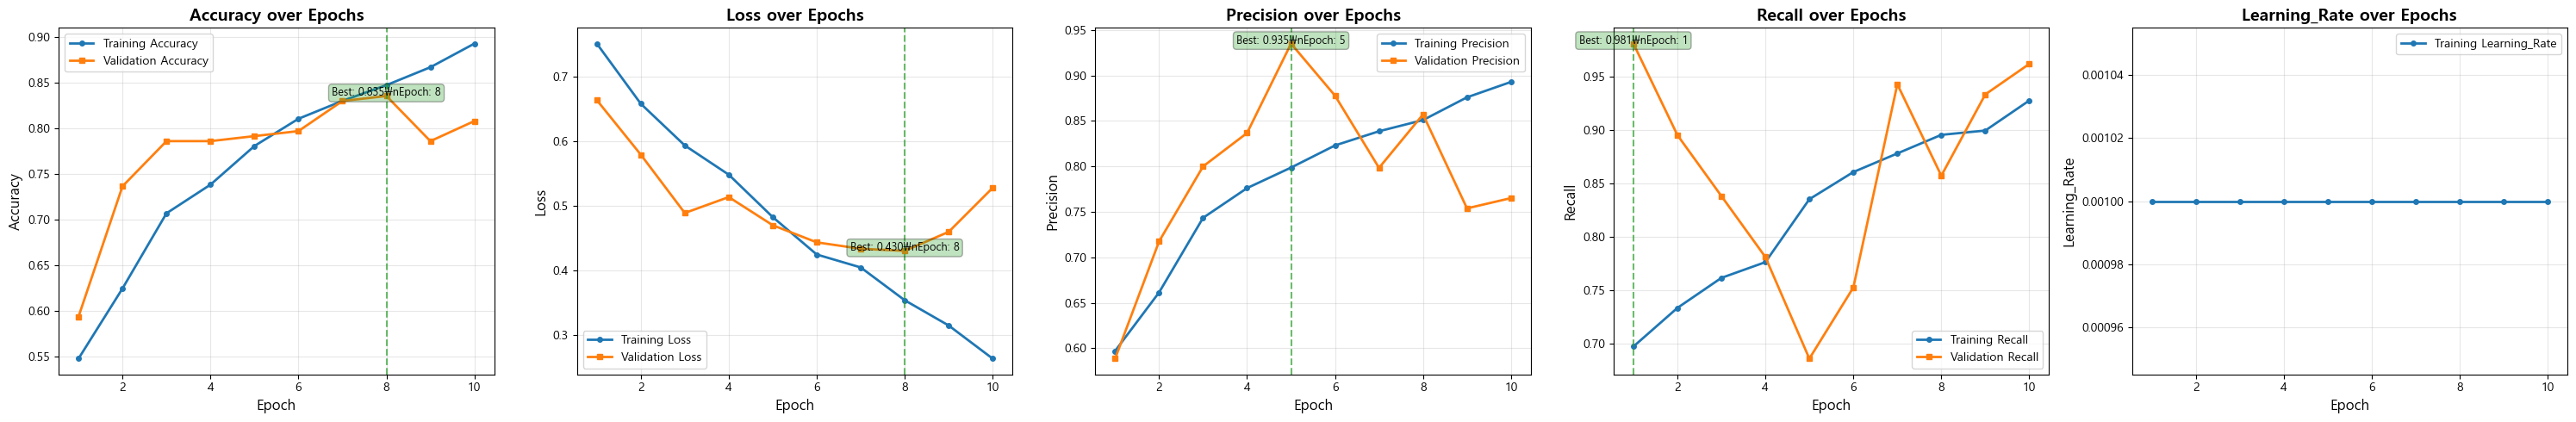


📈 학습 요약:
  🔹 총 에포크: 10
  🔹 최종 accuracy: 훈련 0.8925, 검증 0.8077
  🔹 최고 검증 accuracy: 0.8352 (에포크 8)
  🔹 최종 loss: 훈련 0.2627, 검증 0.5275
  🔹 최고 검증 loss: 0.4298 (에포크 8)
  🔹 최종 precision: 훈련 0.8929, 검증 0.7652
  🔹 최고 검증 precision: 0.9351 (에포크 5)
  🔹 최종 recall: 훈련 0.9276, 검증 0.9619
  🔹 최고 검증 recall: 0.9810 (에포크 1)
  🔹 최종 learning_rate: 0.0010
🔍 상세 모델 평가 진행 중...
📊 상세 성능 평가 결과:
🌸 Daisy:
   정밀도(Precision): 0.8052
   재현율(Recall):     0.8052
   F1-점수:           0.8052
   지원 샘플:         77

🌸 Dandelion:
   정밀도(Precision): 0.8571
   재현율(Recall):     0.8571
   F1-점수:           0.8571
   지원 샘플:         105

📈 전체 성능:
   정확도:            0.8352
   매크로 평균 F1:    0.8312
   가중 평균 F1:      0.8352
  ✅ 혼동행렬 저장: ../../data/img/confusion_matrix.png


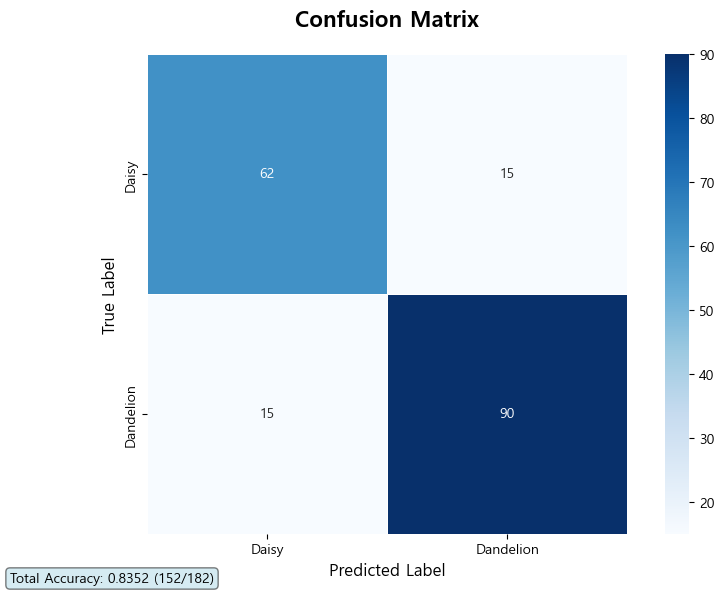

🖼️ 12개 샘플 예측 시각화 중...
  ✅ 샘플 예측 결과 저장: ../../data/img/sample_predictions.png


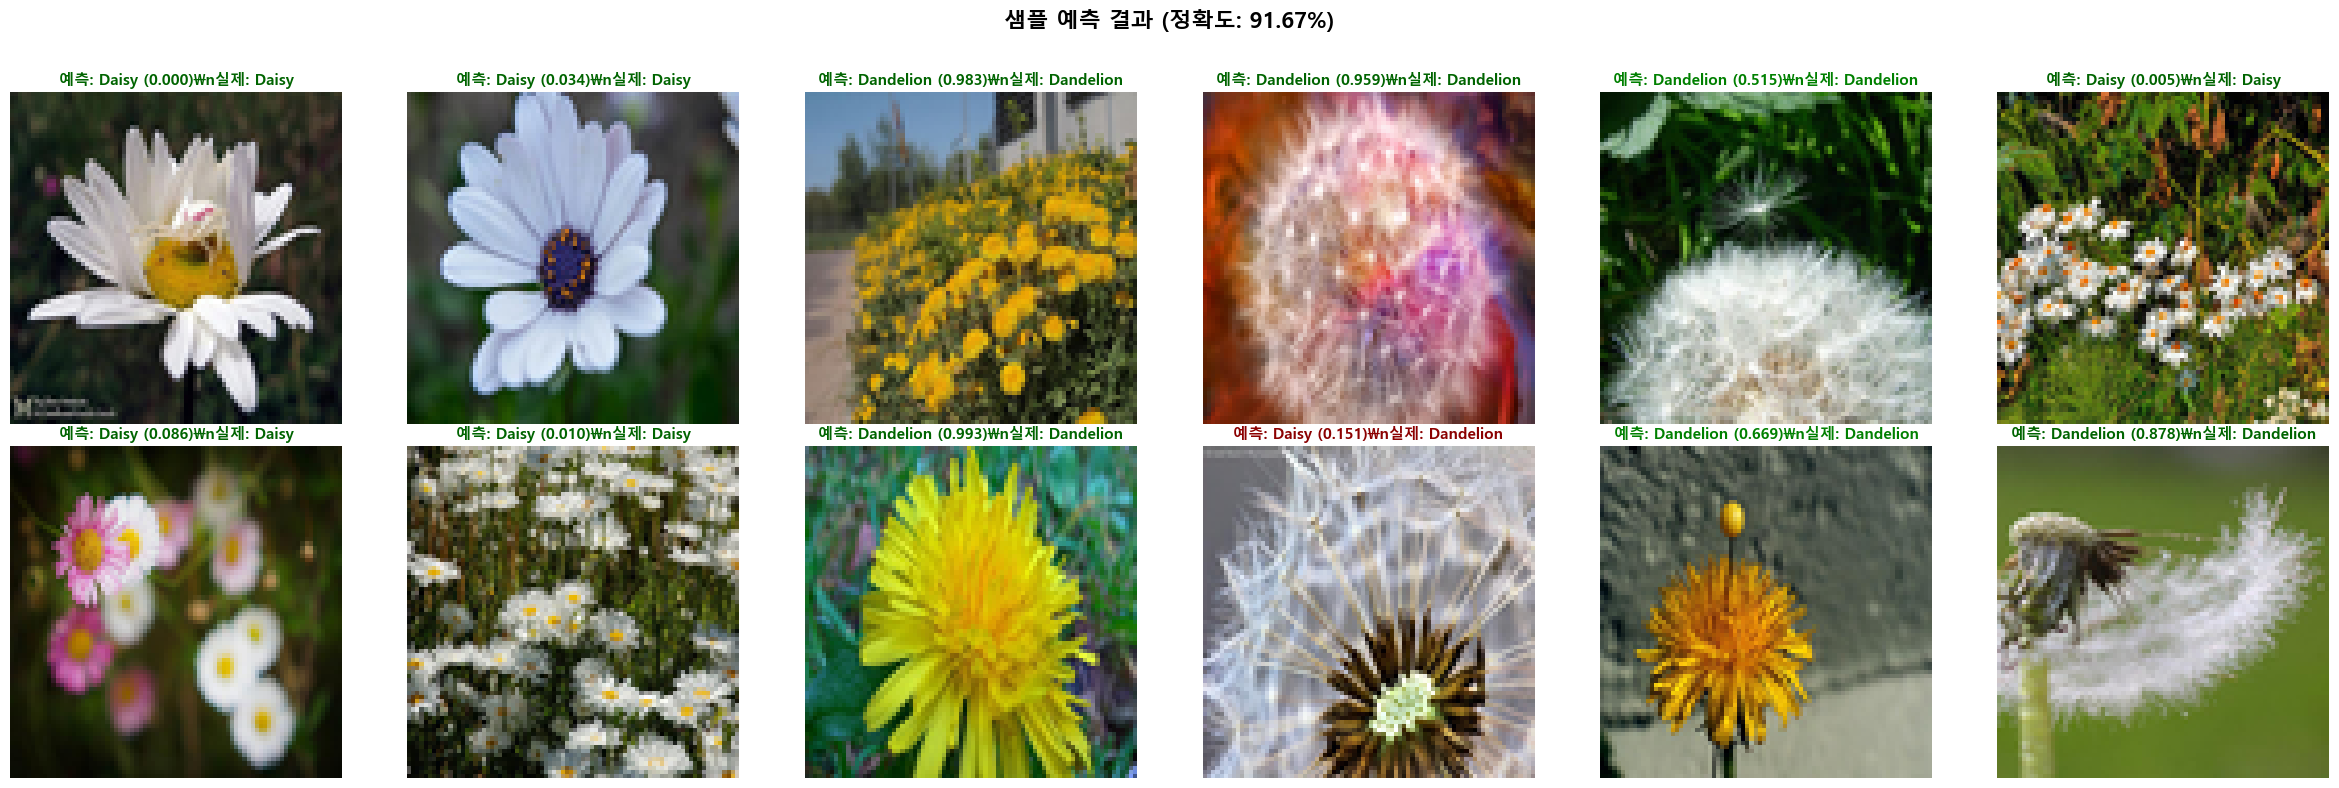

📊 샘플 분석 결과:
  🔹 정확 예측: 11/12 (91.67%)
  🔹 오류 예측: 1/12

🎉 모든 분석 완료!


In [22]:
# =============================================================================
# 4️⃣ 4단계: 결과 분석 및 시각화
# =============================================================================

print("4️⃣ 결과 분석 및 시각화...")

# 전처리된 데이터 로드
X_train, y_train, X_test, y_test = preprocessing()

if X_test is not None and model is not None:
    # 학습 곡선 시각화
    plot_training_history(history, save_path="../../data/img/training_history.png")
    
    # 상세 성능 평가
    y_pred, y_pred_prob = evaluate_model_detailed(
        model, X_test, y_test, 
        save_path="../../data/img/confusion_matrix.png"
    )
    
    # 샘플 예측 시각화
    show_sample_predictions(
        model, X_test, y_test, 
        num_samples=12,
        save_path="../../data/img/sample_predictions.png"
    )
    
    print("\n🎉 모든 분석 완료!")
else:
    print("❌ 데이터 또는 모델이 준비되지 않았습니다.")


In [ ]:
# =============================================================================
# 5️⃣ 5단계: 개별 함수 테스트 (선택사항)
# =============================================================================

print("5️⃣ 개별 함수 테스트...")

# 데이터만 로드하여 확인
X_train, y_train, X_test, y_test = loadData()

# 전처리만 테스트
X_train_scaled, y_train, X_test_scaled, y_test = preprocessing()

# 모델만 생성하여 구조 확인
test_model = createModel(summary=True)


In [23]:
# =============================================================================
# 📄 생성되는 파일 안내
# =============================================================================

print("="*80)
print("🎯 실행 완료 후 다음과 같은 파일들이 생성됩니다:")
print("  📄 imagedata*.npz - 전처리된 이미지 데이터")
print("  🤖 *_final.h5 - 훈련된 모델 파일")
print("  📋 *_info.json - 모델 정보")
print("  📊 *.png - 분석 결과 이미지")
print("="*80)


🎯 실행 완료 후 다음과 같은 파일들이 생성됩니다:
  📄 imagedata*.npz - 전처리된 이미지 데이터
  🤖 *_final.h5 - 훈련된 모델 파일
  📋 *_info.json - 모델 정보
  📊 *.png - 분석 결과 이미지


## 📋 7. 프로젝트 정리 및 확장 방안

### 7.1 현재 구현된 기능

#### ✅ 완성된 기능들:
- **데이터 파이프라인**: 이미지 전처리, 정규화, 배치 처리
- **CNN 모델**: Conv2D, MaxPooling, Dropout이 포함된 최적화된 구조
- **학습 시스템**: 조기 종료, 학습률 스케줄링 등 고급 기능
- **평가 도구**: 혼동행렬, 분류 리포트, 시각화
- **모델 관리**: 자동 저장, 메타데이터 기록

#### 🔧 기술적 특징:
- **메모리 효율성**: NPZ 압축 형식으로 데이터 저장
- **확장성**: 모듈화된 함수 구조로 쉬운 수정 가능
- **재현성**: 랜덤 시드 고정으로 결과 재현 보장
- **사용자 친화성**: 상세한 진행률 표시 및 오류 처리

### 7.2 개선 및 확장 가능 사항

#### 🚀 성능 향상 방안:

1. **모델 아키텍처 개선**:
   ```python
   # 배치 정규화 추가
   layers.BatchNormalization()
   
   # ResNet 스타일 잔차 연결
   # VGG, ResNet 등 사전 훈련된 모델 활용
   ```

2. **데이터 증강**:
   ```python
   from tensorflow.keras.preprocessing.image import ImageDataGenerator
   
   datagen = ImageDataGenerator(
       rotation_range=30,
       width_shift_range=0.3,
       height_shift_range=0.3,
       horizontal_flip=True,
       zoom_range=0.3,
       brightness_range=[0.8, 1.2],
       fill_mode='nearest'
   )
   ```

3. **고급 최적화 기법**:
   - **Learning Rate Scheduling**: 코사인 어닐링, 웜업
   - **정규화 기법**: L1/L2 정규화, 스펙트럴 정규화
   - **앙상블 기법**: 여러 모델의 결과 조합

#### 📊 확장 가능한 기능들:

1. **다중 클래스 분류**: 더 많은 꽃 종류 추가
2. **실시간 분류**: 웹캠을 통한 실시간 예측
3. **모바일 배포**: TensorFlow Lite로 모바일 최적화
4. **웹 서비스**: Flask/FastAPI를 통한 API 서버 구축

### 7.3 실제 운영 고려사항

#### 💡 배포 전 체크리스트:
- [ ] 다양한 해상도 이미지 테스트
- [ ] 메모리 사용량 프로파일링
- [ ] 모델 추론 속도 벤치마크
- [ ] 엣지 케이스 처리 (흐릿한 이미지, 다른 객체 등)
- [ ] A/B 테스트를 통한 성능 검증

#### 🔒 보안 및 품질 관리:
- **모델 버전 관리**: MLflow, DVC 등 활용
- **데이터 검증**: 입력 데이터 형식 및 크기 검증
- **모니터링**: 예측 성능 실시간 모니터링
- **롤백 시스템**: 문제 발생 시 이전 버전으로 복구

이 프로젝트는 기본적인 이미지 분류부터 실제 운영 가능한 시스템까지의 완전한 파이프라인을 제공합니다. 🌸✨


In [24]:
# =============================================================================
# 프로젝트 완료 - 요약 및 다음 단계
# =============================================================================

print("="*80)
print("🎉 꽃 분류 CNN 프로젝트 완료!")
print("="*80)
print()
print("📋 프로젝트 요약:")
print("  • 목표: Daisy vs Dandelion 이진 분류")
print("  • 기술: CNN, TensorFlow/Keras") 
print("  • 특징: 완전 자동화된 파이프라인")
print()
print("🛠️ 구현된 주요 기능:")
print("  ✓ 이미지 데이터 전처리 및 정규화")
print("  ✓ 최적화된 CNN 모델 아키텍처")
print("  ✓ 고급 학습 기법 (조기 종료, 학습률 스케줄링)")
print("  ✓ 상세한 성능 평가 및 시각화")
print("  ✓ 모델 저장 및 메타데이터 관리")
print()
print("🚀 다음 학습 방향:")
print("  • 전이 학습 (Transfer Learning)")
print("  • 고급 데이터 증강 기법")
print("  • 모델 앙상블 및 최적화")
print("  • 실시간 추론 시스템 구축")
print("  • 웹/모바일 앱 배포")
print()
print("📚 관련 학습 자료:")
print("  • TensorFlow 공식 문서: https://tensorflow.org")
print("  • Keras 가이드: https://keras.io/guides/")
print("  • 컴퓨터 비전 튜토리얼: https://tensorflow.org/tutorials/images")
print()
print("="*80)
print("감사합니다! 즐거운 딥러닝 여정이 되시길 바랍니다! 🌸✨")
print("="*80)


🎉 꽃 분류 CNN 프로젝트 완료!

📋 프로젝트 요약:
  • 목표: Daisy vs Dandelion 이진 분류
  • 기술: CNN, TensorFlow/Keras
  • 특징: 완전 자동화된 파이프라인

🛠️ 구현된 주요 기능:
  ✓ 이미지 데이터 전처리 및 정규화
  ✓ 최적화된 CNN 모델 아키텍처
  ✓ 고급 학습 기법 (조기 종료, 학습률 스케줄링)
  ✓ 상세한 성능 평가 및 시각화
  ✓ 모델 저장 및 메타데이터 관리

🚀 다음 학습 방향:
  • 전이 학습 (Transfer Learning)
  • 고급 데이터 증강 기법
  • 모델 앙상블 및 최적화
  • 실시간 추론 시스템 구축
  • 웹/모바일 앱 배포

📚 관련 학습 자료:
  • TensorFlow 공식 문서: https://tensorflow.org
  • Keras 가이드: https://keras.io/guides/
  • 컴퓨터 비전 튜토리얼: https://tensorflow.org/tutorials/images

감사합니다! 즐거운 딥러닝 여정이 되시길 바랍니다! 🌸✨
